In [1]:
import cv2
import glob
import mlflow
import random 
import os
from scipy import io
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.optimizers import *
from keras.models import *
from keras.layers import *
from keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from warnings import filterwarnings
filterwarnings(action='ignore')
from keras.applications import * 
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import *
from keras import regularizers

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
iterate = np.arange(0, 10000)
iterate = iter(iterate)

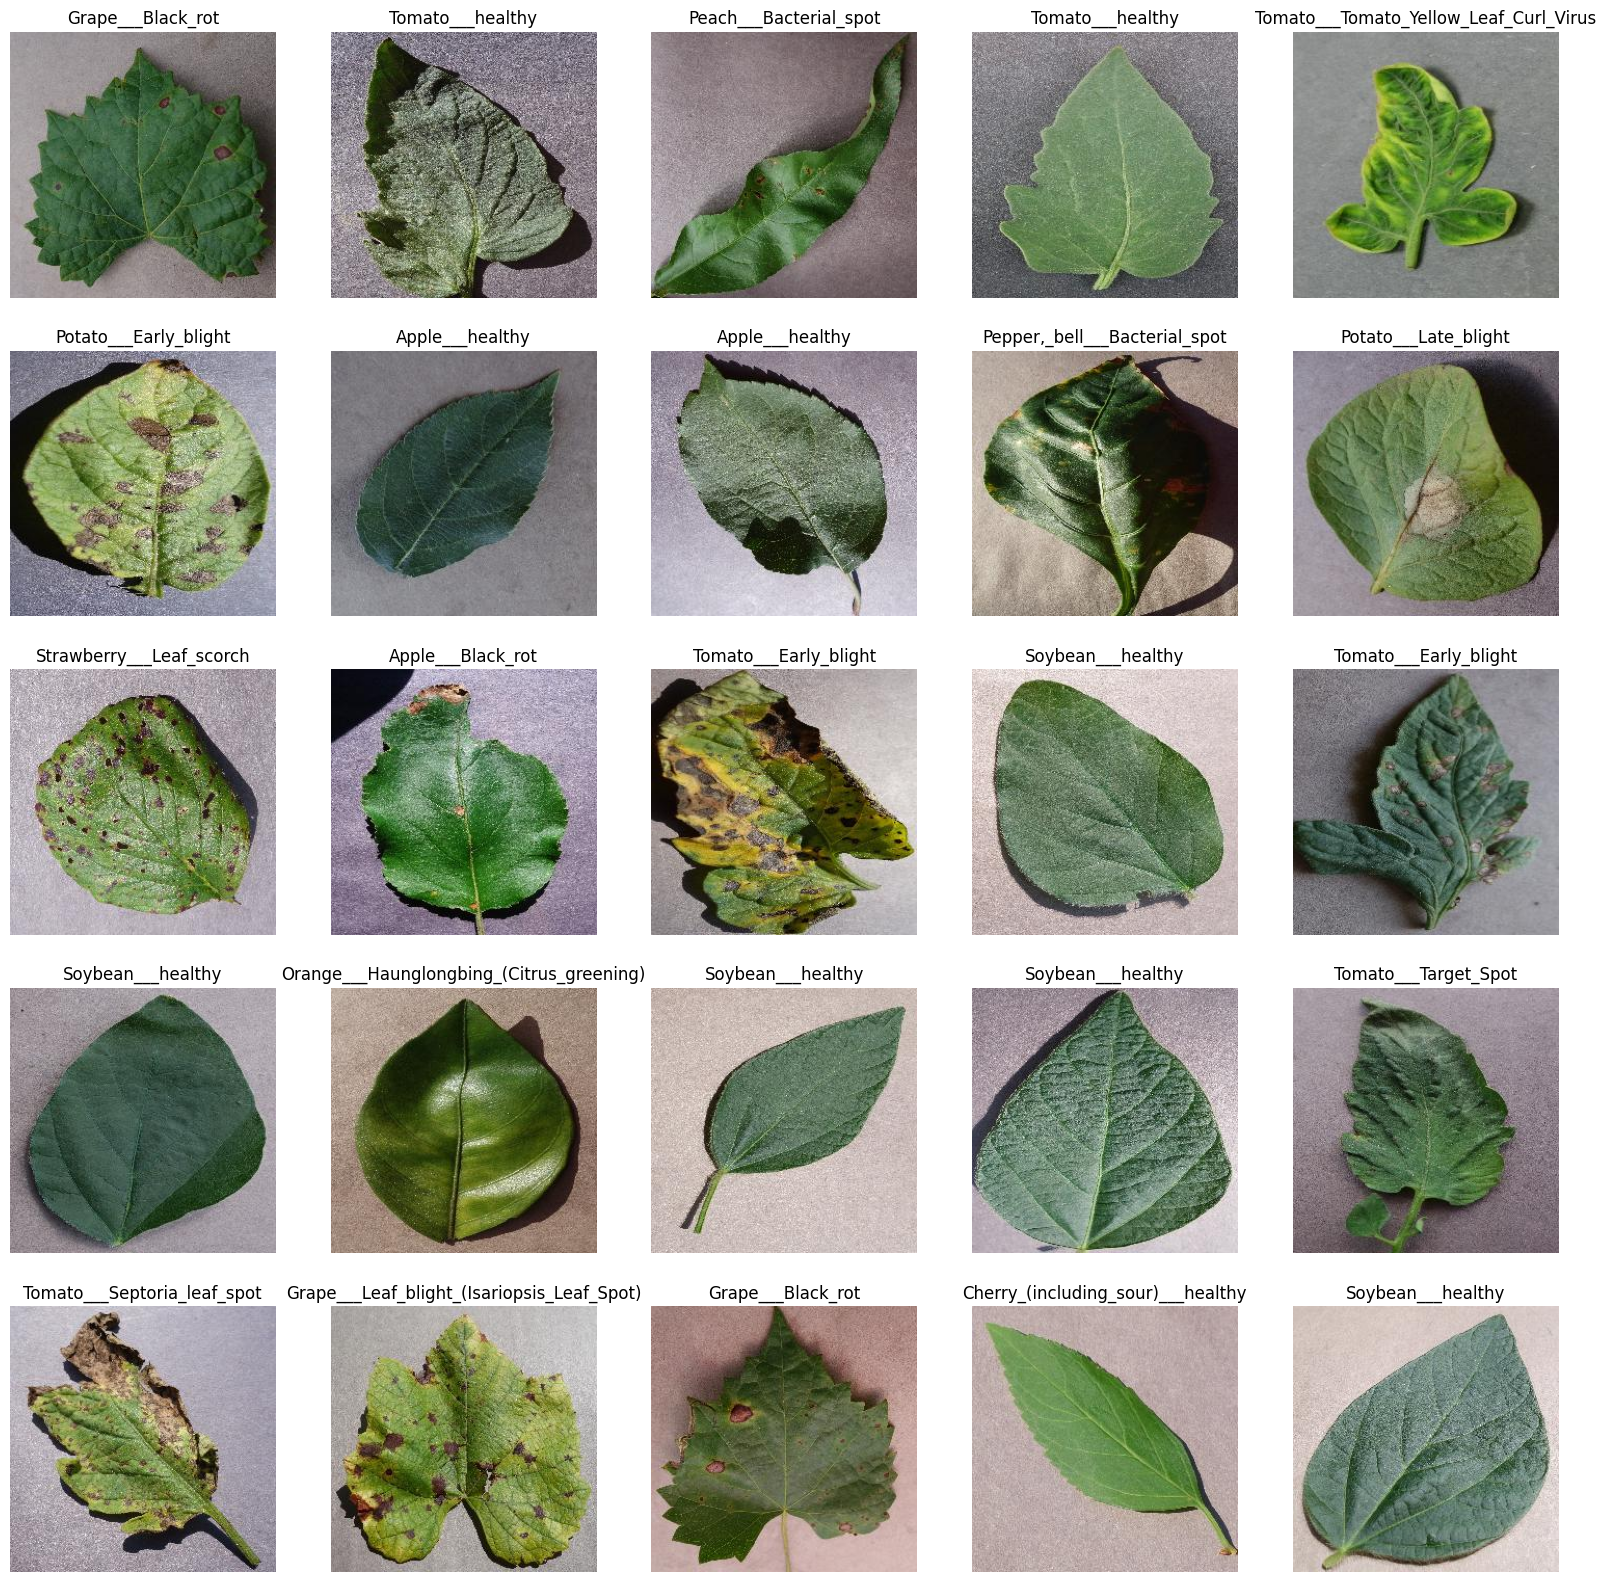

In [4]:
random_imgs = random.sample(glob.glob('plantvillage dataset/color/*/*'), 25)
fig, axes = plt.subplots(5, 5, figsize= (20, 20))
for i, ax in enumerate(axes.flatten()):
    ax.set_title(random_imgs[i].split('\\')[1])
    img = cv2.imread(random_imgs[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [5]:
classes = os.listdir('plantvillage dataset/color')
calss_dict = {item: index for index, item in enumerate(classes) }
labels = []
data = []
for i in glob.glob('plantvillage dataset/color/*/*'):
    labels.append(calss_dict[i.split('\\')[1]])
    data.append(i)

In [6]:
df = pd.DataFrame({'data': data, 'labels': labels})
df

data  labels
0      plantvillage dataset/color\Apple___Apple_scab\...       0
1      plantvillage dataset/color\Apple___Apple_scab\...       0
2      plantvillage dataset/color\Apple___Apple_scab\...       0
3      plantvillage dataset/color\Apple___Apple_scab\...       0
4      plantvillage dataset/color\Apple___Apple_scab\...       0
...                                                  ...     ...
54300  plantvillage dataset/color\Tomato___Tomato_Yel...      37
54301  plantvillage dataset/color\Tomato___Tomato_Yel...      37
54302  plantvillage dataset/color\Tomato___Tomato_Yel...      37
54303  plantvillage dataset/color\Tomato___Tomato_Yel...      37
54304  plantvillage dataset/color\Tomato___Tomato_Yel...      37

[54305 rows x 2 columns]

In [7]:
class Generate_model():
    
    def __init__(self, Version='VGG16', Input_shape=(128, 128, 3), Batch_size=32, lr=1e-3, iterate=iterate):
        self.Version = Version
        self.Input_shape = Input_shape
        self.Batch_size = Batch_size
        self.lr = lr
        self.iterate = iterate

    def Data_Generator(self):
        x = df['data']
        y = df['labels']
        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.9, stratify= y)
        x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, train_size=0.5, stratify=y_test)
        train = pd.DataFrame({'data': x_train, 'labels': y_train}).astype('str')
        test = pd.DataFrame({'data': x_test, 'labels': y_test}).astype('str')
        val = pd.DataFrame({'data': x_val, 'labels': y_val}).astype('str')
        train_datagen = ImageDataGenerator(
                           rotation_range=40, 
                           width_shift_range=0.2, height_shift_range=0.2, 
                           horizontal_flip=True, fill_mode='nearest', zoom_range= 0.2,
                            shear_range=0.2, 
                           preprocessing_function=preprocess_input)

        test_datagen = ImageDataGenerator(
            preprocessing_function=preprocess_input )

        val_datagen = ImageDataGenerator(
            preprocessing_function=preprocess_input)
        train_data = train_datagen.flow_from_dataframe(train, x_col='data', y_col='labels', color_mode='rgb', class_mode='categorical', target_size=(224, 224), shuffle=True)
        test_data = test_datagen.flow_from_dataframe(test, x_col='data', y_col='labels', color_mode='rgb', class_mode='categorical', target_size=(224, 224),  shuffle=True)
        val_data = val_datagen.flow_from_dataframe(val, x_col='data', y_col='labels', color_mode='rgb', class_mode='categorical', target_size=(224, 224), shuffle=True)
        return train_data, val_data, test_data
    
    def _select_model(self, train, val):
        
        if self.Version ==  'VGG16':
            Base = VGG16(include_top=False, input_shape=self.Input_shape)
            
        elif self.Version ==  'ResNet':
            Base = ResNet50(include_top=False, input_shape=self.Input_shape)
            
        elif self.Version ==  'MobileNet':
            Base = MobileNet(include_top=False, input_shape=self.Input_shape)
        
        else:
            raise ValueError(f"Invalid Version: {self.Version}")
            
            
        for layer in Base.layers[:-5]:
            layer.trainable = False

        model = Sequential()

        model.add(Base)

        model.add(GlobalAveragePooling2D())

        model.add(Flatten())

        model.add(BatchNormalization())

        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu',
                        # kernel_regularizer=regularizers.l1_l2(l1=0.9, l2=0.9)
                 ))

        model.add(Dropout(0.2))
        model.add(Dense(128, activation='relu', 
                        # kernel_regularizer=regularizers.l1_l2(l1=0.9, l2=0.9)
                 ))
        model.add(Dropout(0.2))

        model.add(Dense(38, activation='softmax'))
        model.compile(Adam(lr= self.lr), loss='categorical_crossentropy', metrics=['accuracy', 'Recall', 'Precision'])

        history = model.fit(train, validation_data=val, batch_size=self.Batch_size, epochs=200,
                           callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
                           )
        return model, history, model.summary()
    
    def artifacts(self, model, history):

        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.savefig(f'images/Accuracy_Run({self.iterate})')
        plt.show()
        plt.close()

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.savefig(f'images/Loss_Run({self.iterate})')
        plt.show()
        plt.close()

        plt.plot(history.history['recall'])
        plt.plot(history.history['val_recall'])
        plt.title('Model Recall')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.savefig(f'images/Recall_Run({self.iterate})')
        plt.show()
        plt.close()

        plt.plot(history.history['precision'])
        plt.plot(history.history['val_precision'])
        plt.title('Model precision')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.savefig(f'images/Prescision_Run({self.iterate})')
        plt.show()
        plt.close()
        
    def train_model(self):
        train, val, test = self.Data_Generator()
        model, history, summary = self._select_model(train, val)
        self.artifacts(model, history)
        return model, history, summary

Found 48874 validated image filenames belonging to 38 classes.
Found 2715 validated image filenames belonging to 38 classes.
Found 2716 validated image filenames belonging to 38 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

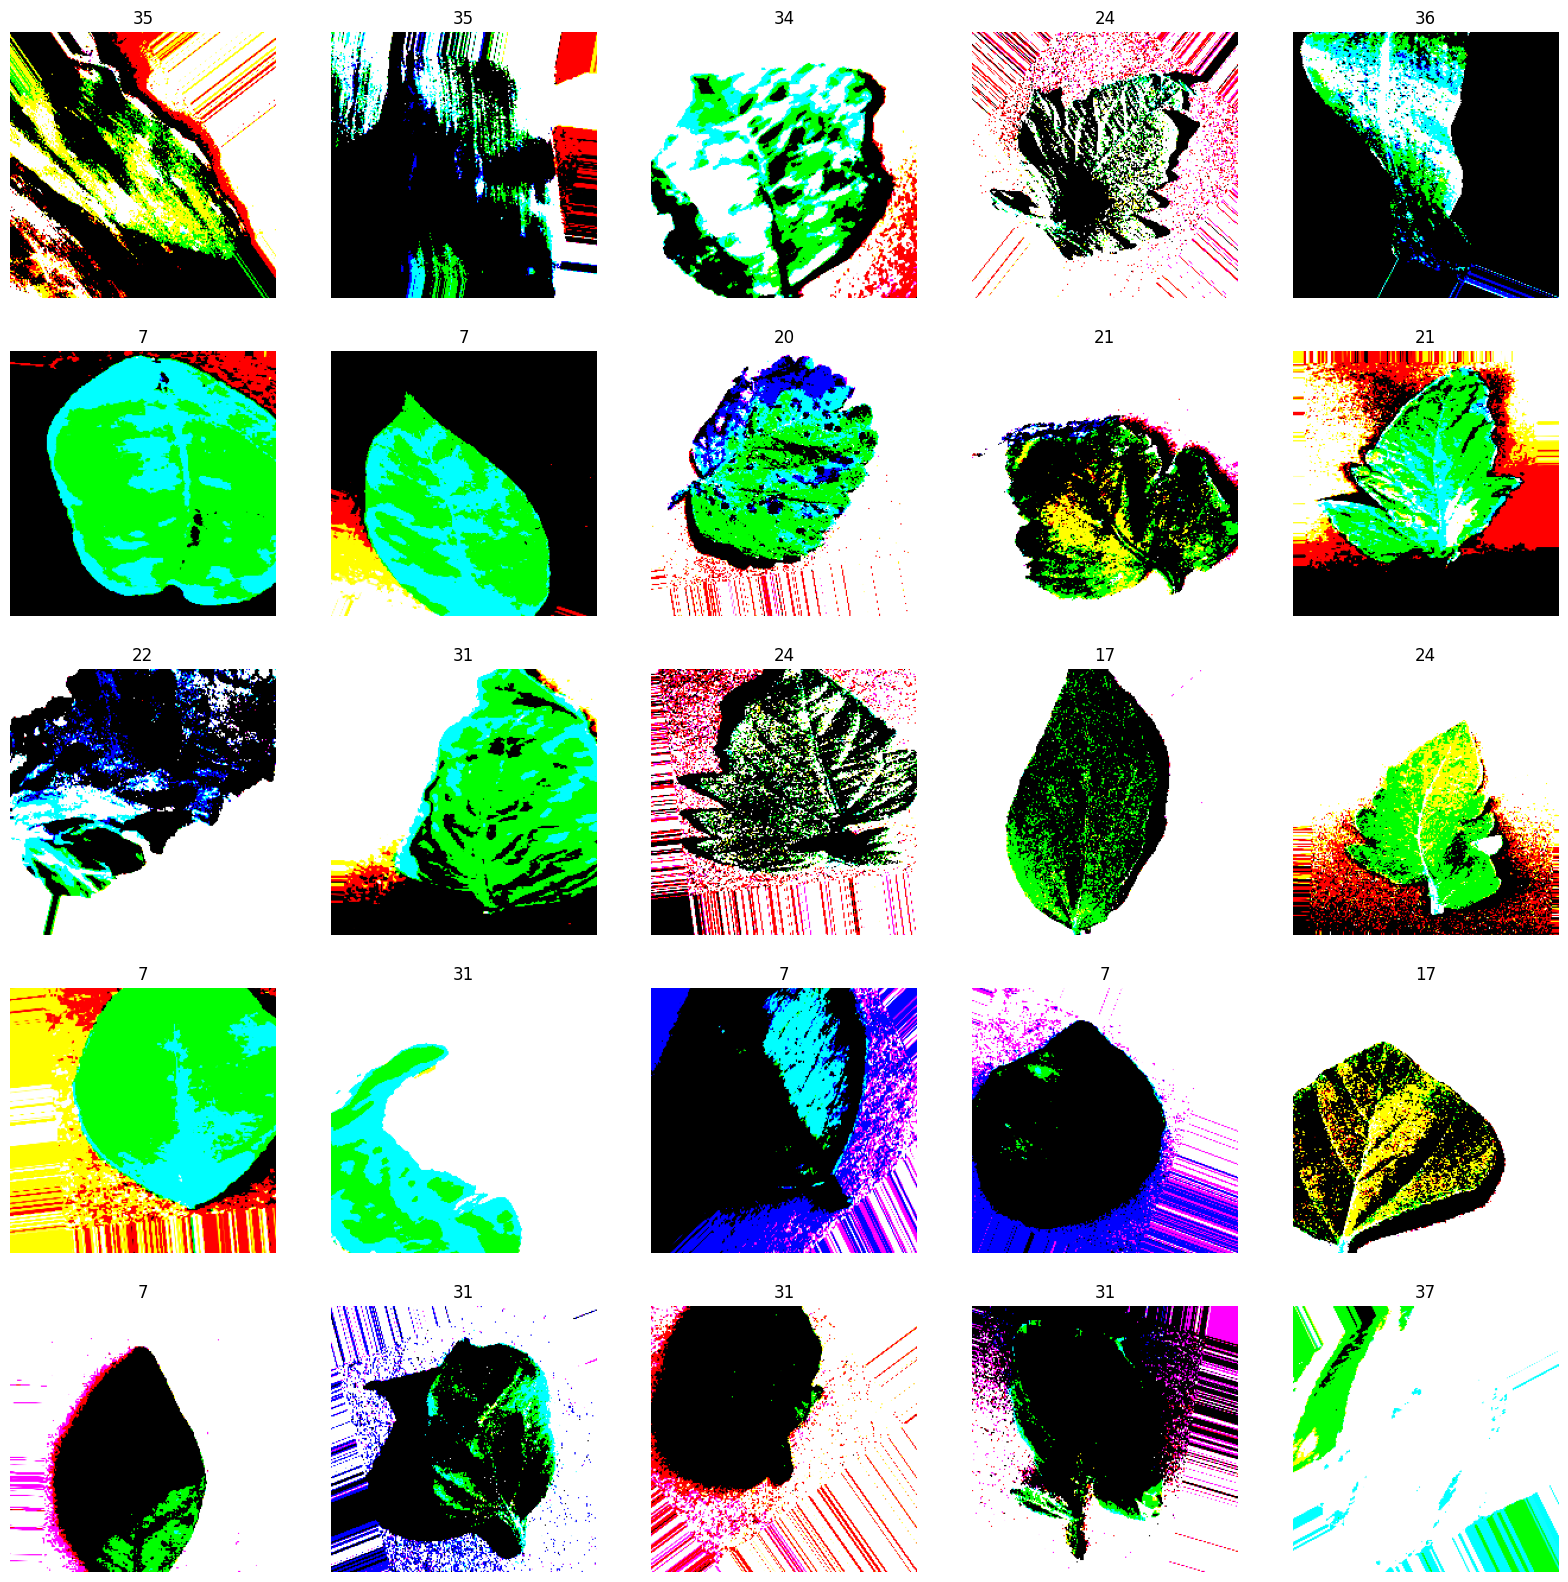

In [8]:
train, val, test = Generate_model().Data_Generator()
fig, axes = plt.subplots(5, 5, figsize= (20, 20))
for i, ax in enumerate(axes.flatten()):
    ax.set_title(np.argmax(train[0][1][i]))
    ax.imshow(train[0][0][i])
    ax.axis('off')
    
plt.show()

Found 48874 validated image filenames belonging to 38 classes.
Found 2715 validated image filenames belonging to 38 classes.
Found 2716 validated image filenames belonging to 38 classes.
Found 48874 validated image filenames belonging to 38 classes.
Found 2715 validated image filenames belonging to 38 classes.
Found 2716 validated image filenames belonging to 38 classes.
58889256/58889256 [==============================] - 66s 1us/step
Epoch 1/200
1528/1528 [==============================] - 1772s 1s/step - loss: 0.5556 - accuracy: 0.8534 - recall: 0.7831 - precision: 0.9484 - val_loss: 0.2155 - val_accuracy: 0.9418 - val_recall: 0.9374 - val_precision: 0.9532
Epoch 2/200
1528/1528 [==============================] - 670s 438ms/step - loss: 0.1372 - accuracy: 0.9577 - recall: 0.9484 - precision: 0.9681 - val_loss: 0.1236 - val_accuracy: 0.9602 - val_recall: 0.9580 - val_precision: 0.9637
Epoch 3/200
1528/1528 [==============================] - 558s 365ms/step - loss: 0.0956 - accuracy: 

2023/07/30 17:00:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               2

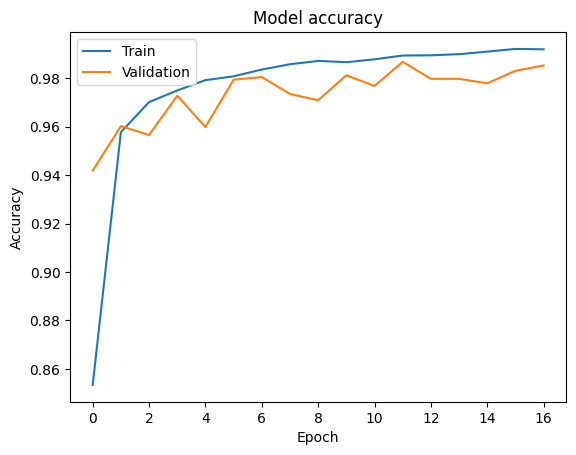

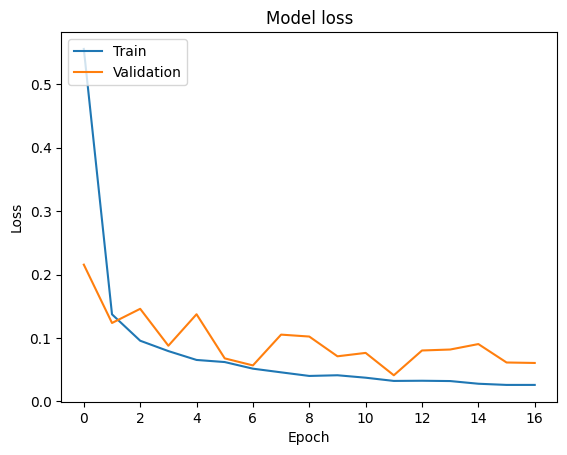

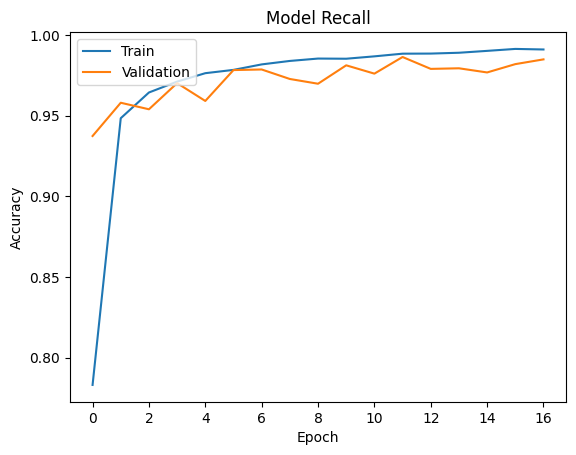

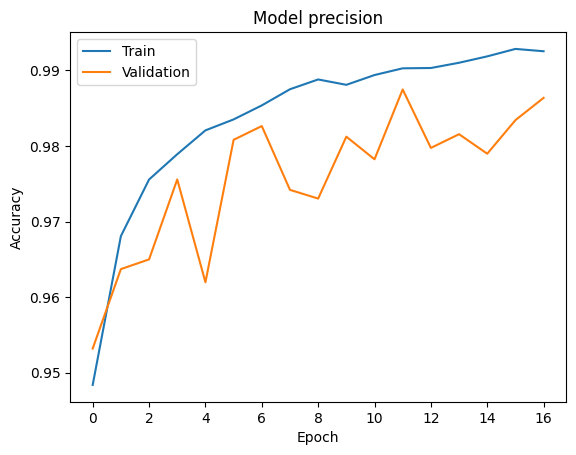

85/85 [==============================] - 9s 101ms/step - loss: 0.0214 - accuracy: 0.9923 - recall: 0.9919 - precision: 0.9926


2023/07/30 17:10:54 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmp6ss2qx29\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmp6ss2qx29\model\data\model\assets


In [26]:
Version = 'VGG16'
iterate_ = next(iterate)

mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment(experiment_name=Version)
mlflow.start_run(run_name=f"run_{iterate_}")
mlflow.tensorflow.autolog()

model_generator = Generate_model(Version=Version, Input_shape=(224, 224, 3), Batch_size=32, lr=1e-4, iterate=iterate_)
train, val, test = model_generator.Data_Generator()
model, history, summary = model_generator.train_model()

mlflow.log_artifact(f'images/Accuracy_Run({iterate_}).png')
mlflow.log_artifact(f'images/Loss_Run({iterate_}).png')
mlflow.log_artifact(f'images/Recall_Run({iterate_}).png')
mlflow.log_artifact(f'images/Prescision_Run({iterate_}).png')


train_metrics = model.evaluate(train) 
val_metrics = model.evaluate(val)

mlflow.log_metric('loss', train_metrics[0])
mlflow.log_metric('accuracy', train_metrics[1])
mlflow.log_metric('recall', train_metrics[2])
mlflow.log_metric('precision', train_metrics[3])

mlflow.log_metric('val_loss', val_metrics[0])
mlflow.log_metric('val_accuracy', val_metrics[1])
mlflow.log_metric('val_recall', val_metrics[2])
mlflow.log_metric('val_precision', val_metrics[3])

mlflow.tensorflow.log_model(model, 'model')

mlflow.end_run()

In [34]:
def plot_artifacts(run_id):
    fig, axes = plt.subplots(4, 1, figsize=(50, 40))
    for i, path in enumerate(glob.glob(f'artifacts/1/{run_id}/artifacts/*.png')):
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i].imshow(image)
        axes[i].axis('off')
    plt.show()

def Evaluate_metrics(run_id, train_data = train, val_data = val, test= test):
    final_model = mlflow.tensorflow.load_model(f'runs:/{run_id}/model')
    train = final_model.evaluate(train_data)
    val = final_model.evaluate(val_data)
    test = final_model.evaluate(test)
    
    print('-' * 50)
    print('-' * 50)

    print(f'Train Loss: {train[0]}\nTrain Accuracy: {train[1]}\nTrain Recall: {train[2]}\nTrain Precision: {train[3]}')
    
    print('-' * 50)
    print('-' * 50)

    print(f'Validation Loss: {val[0]}\nValidation Accuracy: {val[1]}\nValidation Recall: {val[2]}\nValidation Precision: {val[3]}')
    
    print('-' * 50)
    print('-' * 50)
    
    print(f'Test Loss: {test[0]}\nTest Accuracy: {test[1]}\nTest Recall: {test[2]}\nTest Precision: {test[3]}')
    
    print('-' * 50)
    print('-' * 50)

    return final_model


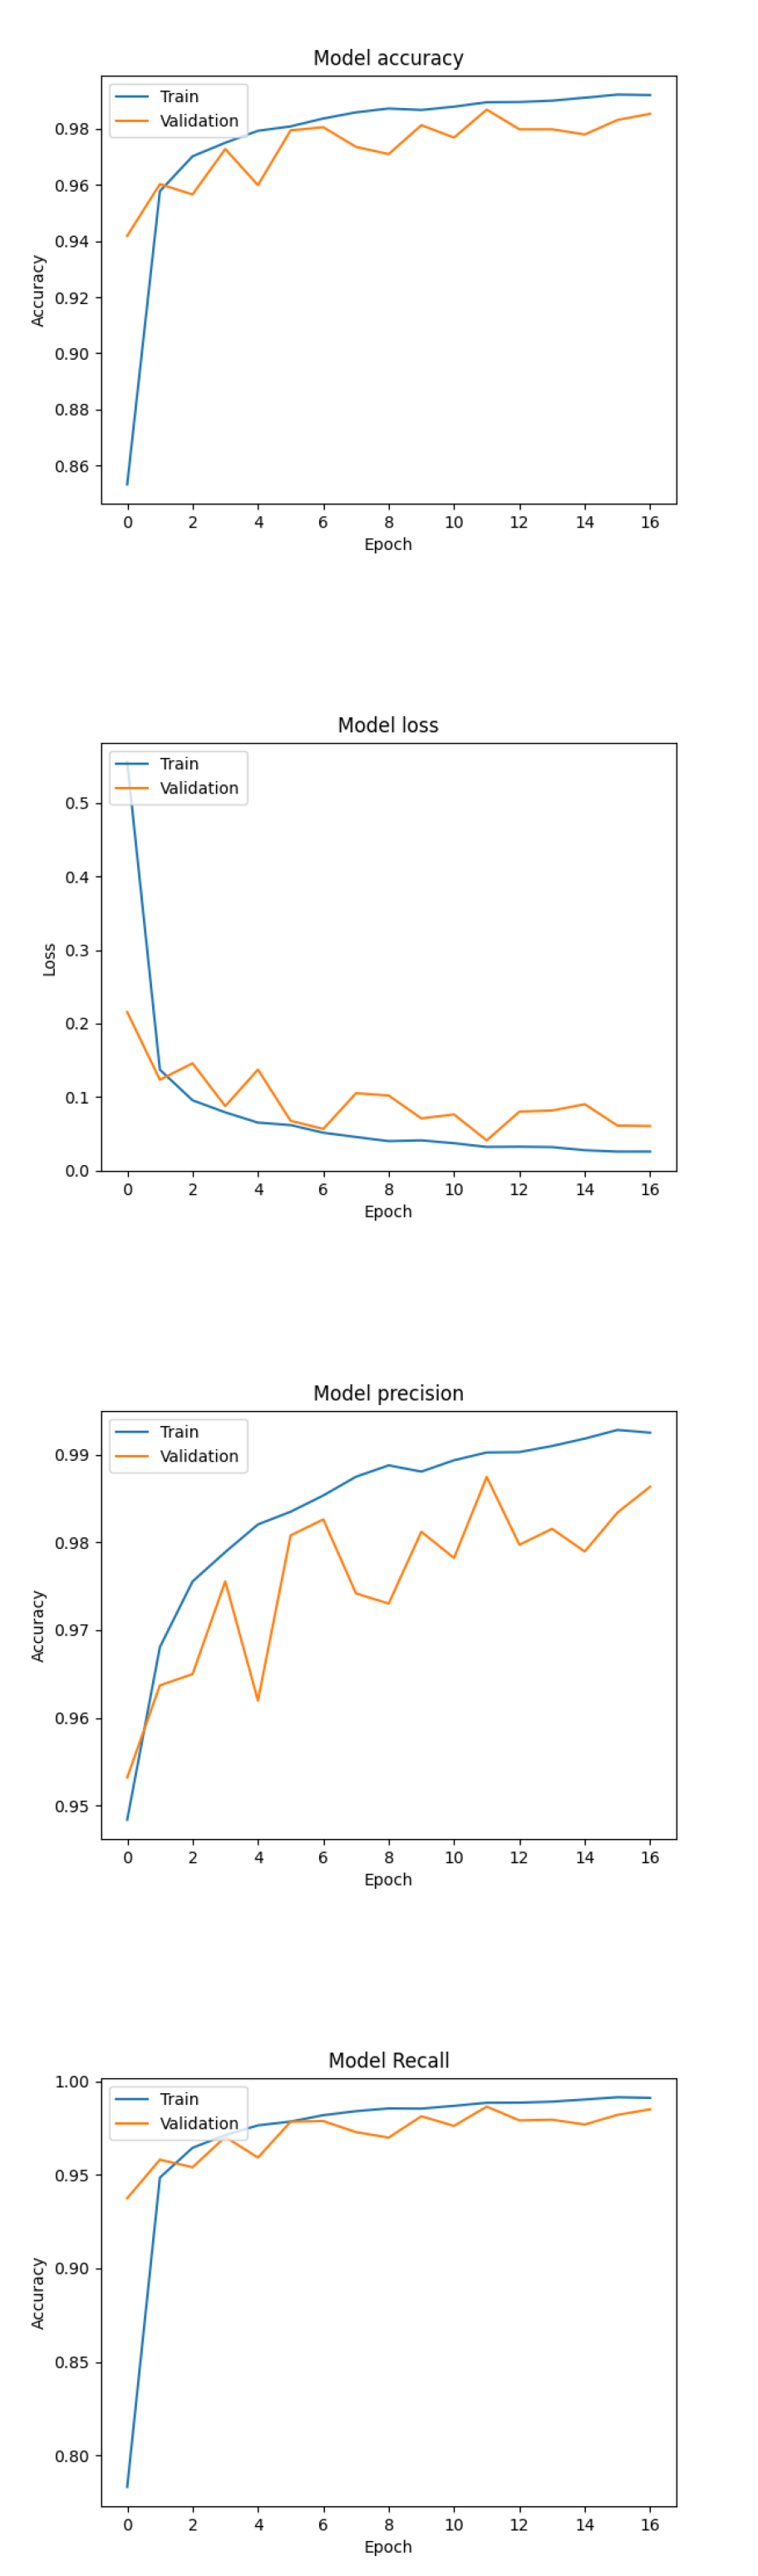

In [35]:
plot_artifacts('5fabb640f4ac4891bcb8a1a3d13368d4')

In [36]:
final_model = Evaluate_metrics('5fabb640f4ac4891bcb8a1a3d13368d4')

85/85 [==============================] - 9s 104ms/step - loss: 0.0230 - accuracy: 0.9945 - recall: 0.9945 - precision: 0.9948
--------------------------------------------------
--------------------------------------------------
Train Loss: 0.025903742760419846
Train Accuracy: 0.9917134046554565
Train Recall: 0.9911404848098755
Train Precision: 0.9923993945121765
--------------------------------------------------
--------------------------------------------------
Validation Loss: 0.021373819559812546
Validation Accuracy: 0.9922680258750916
Validation Recall: 0.991899847984314
Validation Precision: 0.9926307797431946
--------------------------------------------------
--------------------------------------------------
Test Loss: 0.0230161901563406
Test Accuracy: 0.9944751262664795
Test Recall: 0.9944751262664795
Test Precision: 0.9948415756225586
--------------------------------------------------
--------------------------------------------------


1/1 [==============================] - 0s 42ms/step


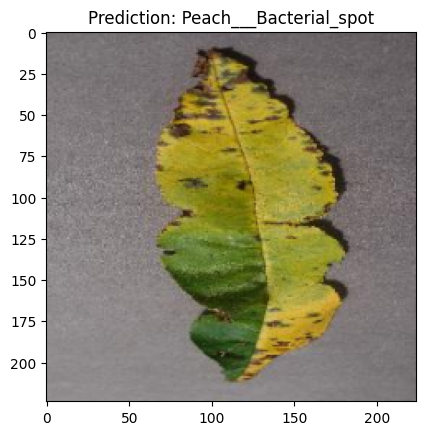

In [45]:
clss = list(train.class_indices.keys())
img = cv2.imread('plantvillage dataset/color/Peach___Bacterial_spot/00f87dfc-bf6c-481e-9022-bfb98224d4b7___Rutg._Bact.S 1965.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224,224))
plt.imshow(img)
img =np.expand_dims(img,axis=0) 
img = preprocess_input(img)
preds = model.predict(img)
plt.title(f'Prediction: {classes[int(clss[np.argmax(preds)])]}')
plt.show()
# img.shape